Let's explore the response to the Gallup question, "Do you approve or disapprove of the way [first & last name] is handling his job as President?"

In [143]:
# Here are the imports that we'll use throughout this notebook
import os
import pandas as pd
from datetime import datetime
from collections import Counter
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
%matplotlib inline

In [144]:
'''
Here's the path to all the data. The data were copied from http://www.presidency.ucsb.edu/data/popularity.php and saved as tsv
files.

'''
djt_path = os.getcwd() + '/data/djt.tsv'
bho_path = os.getcwd() + '/data/bho.tsv'
gwb_path = os.getcwd() + '/data/gwb.tsv'
wjc_path = os.getcwd() + '/data/wjc.tsv'
ghwb_path = os.getcwd() + '/data/ghwb.tsv'
rwr_path = os.getcwd() + '/data/rwr.tsv'
jec_path = os.getcwd() + '/data/jec.tsv'
grf_path = os.getcwd() + '/data/grf.tsv'
rmn_path = os.getcwd() + '/data/rmn.tsv'
lbj_path = os.getcwd() + '/data/lbj.tsv'
jfk_path = os.getcwd() + '/data/jfk.tsv'
dde_path = os.getcwd() + '/data/dde.tsv'
hst_path = os.getcwd() + '/data/hst.tsv'

In [145]:
# Now let's read in all the data
djt = pd.read_table(djt_path)
bho = pd.read_table(bho_path)
gwb = pd.read_table(gwb_path)
wjc = pd.read_table(wjc_path)
ghwb = pd.read_table(ghwb_path)
rwr = pd.read_table(rwr_path)
jec = pd.read_table(jec_path)
grf = pd.read_table(grf_path)
rmn = pd.read_table(rmn_path)
lbj = pd.read_table(lbj_path)
jfk = pd.read_table(jfk_path)
dde = pd.read_table(dde_path)
hst = pd.read_table(hst_path)
# The first Gallup poll for this question was on 07/22/1941, which was in FDR's third term, so FDR has not been included.

In [146]:
#Let's take a look at Trump's data to see what we've got
djt.head()

,President,Start Date,End Date,Unnamed: 3,Approving,Disapproving,unsure/no data
0,Donald J. Trump,04/04/2017,04/06/2017,NaN,40,54,6
1,,04/03/2017,04/05/2017,NaN,41,53,6
2,,04/02/2017,04/04/2017,NaN,42,52,6
3,,04/01/2017,04/03/2017,NaN,39,55,6
4,,03/31/2017,04/02/2017,NaN,38,57,5


In [147]:
'''OK, looks like we have some DataFrame cleaning to do. The President column is empty except for the first column, so let's
get rid of that. Also, Unnamed" 3 isn't very interesting, so we'll delete that.

'''
# Let's get all the columns names (it helps to view them directly because sometimes there are hidden extra spaces)
djt.columns

Index(['President', 'Start Date', 'End Date', 'Unnamed: 3', 'Approving',
       'Disapproving', 'unsure/no data'],
      dtype='object')

In [148]:
# Let's make a list of all the presidents
presidents = [djt, bho, gwb, wjc, ghwb, rwr, jec, grf, rmn, lbj, jfk, dde, hst]

# And we'll need a list of their names
president_names = ["Donald Trump", "Barack Obama", "George W. Bush", "Bill Clinton", "George H.W. Bush", "Ronald Reagan",
                  "Jimmy Carter", "Gerald Ford", "Richard Nixon", "Lyndon Johnson", "John F. Kennedy", "Dwight Eisenhower",
                  "Harry Truman"]

In [149]:
# There are extra columns in the dataframe that we won't use, so let's remove them
for x in range(len(presidents)):
    del presidents[x]['President']
    del presidents[x]['Unnamed: 3']

In [150]:
# OK, let's see what we've got
djt.head()

,Start Date,End Date,Approving,Disapproving,unsure/no data
0,04/04/2017,04/06/2017,40,54,6
1,04/03/2017,04/05/2017,41,53,6
2,04/02/2017,04/04/2017,42,52,6
3,04/01/2017,04/03/2017,39,55,6
4,03/31/2017,04/02/2017,38,57,5


In [151]:
# We'll need their inauguration dates
inauguration_dates = ['01/20/2017', '01/20/2009', '01/20/2001', '01/20/1993', '01/20/1989', '01/20/1981',
                      '01/20/1977', '08/09/1974', '01/20/1969', '11/22/1963', '01/20/1961', '01/20/1953', '04/12/1945', ]

In [152]:
# Now let's add a column that contains the number of days into their administration

# We'll need a helper function to make the dates easier to work with
def conv(date):
    return datetime.strptime(date, '%m/%d/%Y')

In [153]:
# Let's find how many days into the administration each poll represents
for x in range(len(presidents)):
    presidents[x]['time_in_admin'] = presidents[x]['Start Date'].apply(conv)- conv(inauguration_dates[x])
    # Now let's extract the actual value
    presidents[x]['days_in_admin'] = presidents[x]['time_in_admin'].apply(lambda row: row.days)

In [154]:
djt.head()

,Start Date,End Date,Approving,Disapproving,unsure/no data,time_in_admin,days_in_admin
0,04/04/2017,04/06/2017,40,54,6,74 days,74
1,04/03/2017,04/05/2017,41,53,6,73 days,73
2,04/02/2017,04/04/2017,42,52,6,72 days,72
3,04/01/2017,04/03/2017,39,55,6,71 days,71
4,03/31/2017,04/02/2017,38,57,5,70 days,70


In [155]:
# Polls are not conducted every day. Let's build a function to find the most recent poll numbers for a
# given day if there are no poll number for that day.

def find_closest_date(array, value):
    '''this function could be improved greatly'''
    for x in range(len(array)):
        if array[x] <= value:
            # We want to return x, but we want to make sure there are more
            # polls
            if x == 0:
                # Only return the value if it is exact
                if array[x] == value:
                    return x
                else:
                    break
            return x

In [156]:
# OK, build a function that extracts the minimum and maximum approval rating from a list of all presidents
# Note that I'm not actually using the max part here

def get_min_max(day):
    min_approval = 100 # Set values that will easily be beaten
    max_approval = 0
    for x in range(len(presidents)):
        closest = find_closest_date(presidents[x]['days_in_admin'], day)
        #print("{pres}'s approval rating on his {day}th day was {rating}".format(pres=president_names[x], day=day, rating=presidents[x]['Approving'][closest]))
        if not closest:
            continue
        if presidents[x]['Approving'][closest] < min_approval:
            min_approval = presidents[x]['Approving'][closest]
            min_president = president_names[x]
        if presidents[x]['Approving'][closest] > max_approval:
            max_approval = presidents[x]['Approving'][closest]
            max_president = president_names[x]
    return min_president, min_approval, max_president, max_approval

In [157]:
# A full eight years is around 2920 days (excluding leap years)
# I'm just going to focus on the first 100 days
num_days = 100
# Now let's find which president had the lowest approval rating for each day
min_pres = []
min_value = []
max_pres = []
max_value = []
all_lists = [min_pres, min_value, max_pres, max_value]
for x in range(num_days):
    values = get_min_max(x)
    for x, lst in zip(values, all_lists):
        lst.append(x)

In [158]:
# Let's make a list of a color for each president from Trump to Truman
all_colors = ['#FF0000', '#0000FF', '#FF9F00', '#00DFFF', '#FF00CF', '#8700FF', '#FFFF00', '#B3FF00', 
'#A70053', '#01A129', '#003EB5', '#00EC00', '#000000']

In [159]:
# Now let's combine the names with the colors in a dictionary
colordict = {}
for p, c in zip(president_names, all_colors):
    colordict[p] = c

In [160]:
# We're going to need a list of colors by day. Let's make that now
min_colors = [colordict[min_pres] for min_pres in min_pres]

In [161]:
# There are so many presidents on the list, let's see which ones are actually represented so we don't clutter the graph legend
# with colors that are not used.
print(Counter(min_pres).keys())

dict_keys(['Gerald Ford', 'Donald Trump', 'Bill Clinton'])


In [162]:
# To reduce clutter, we're only going to label presidents who are on the graph
# Let's grab those colors and patches
graph_patches = []
graph_colors = []
for pres in Counter(min_pres).keys():
    graph_colors.append(colordict[pres])
    graph_patches.append(mpatches.Patch(color=colordict[pres], label=pres))

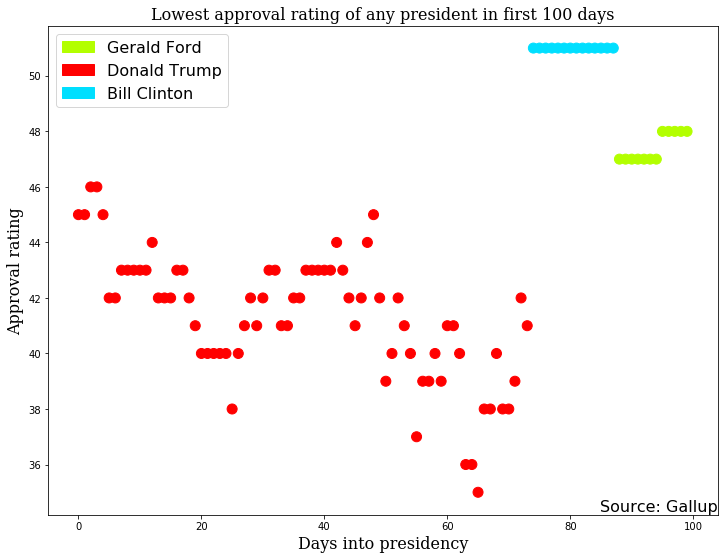

In [165]:
# OK, now let's graph this
a = range(num_days)

plt.scatter(a,min_value, color=min_colors, s=100) # s is the size
plt.legend(handles=graph_patches, prop={'size':16})

# Let's make the plot bigger
# Get current size
fig_size = plt.rcParams["figure.figsize"]
font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 16,
        } 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.title("Lowest approval rating of any president in first 100 days", fontdict = font)
plt.xlabel("Days into presidency", fontdict=font)
plt.ylabel("Approval rating", fontdict=font)
plt.annotate('Source: Gallup', xy=(1, 0), xycoords='axes fraction', fontsize=16,
                horizontalalignment='right', verticalalignment='bottom')
plt.show()

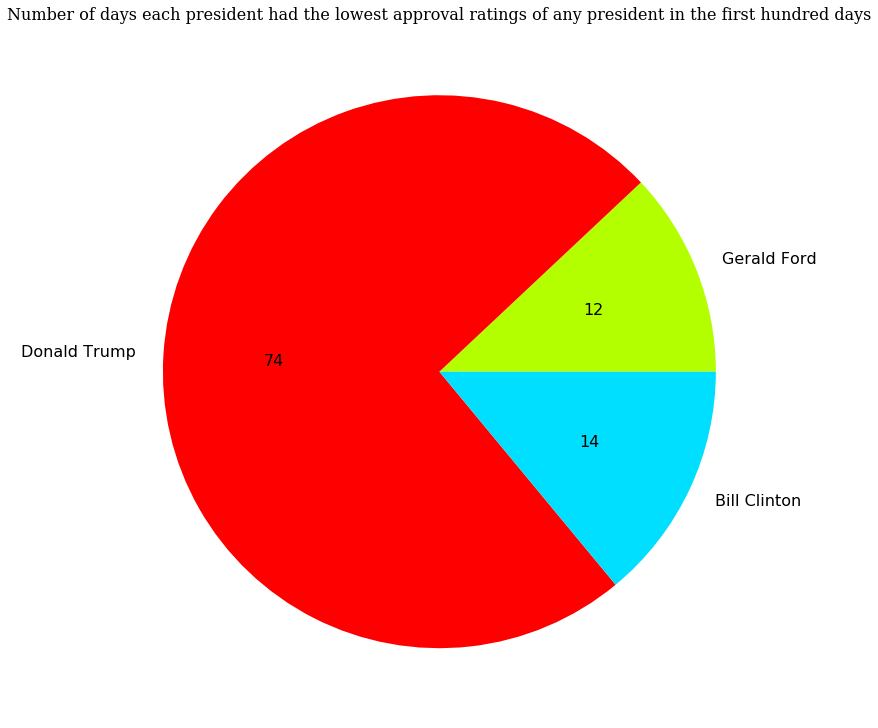

In [164]:
# OK, now let's make a pie chart of what presidents are in the most

fig = plt.figure(1, figsize=(12,12))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
plt.title("Number of days each president had the lowest approval ratings of any president in the first hundred days", fontdict=font)

labels = list(Counter(min_pres).keys())
values = list(Counter(min_pres).values())

patches, texts, autotexts = ax.pie(values, labels=labels, autopct="%1.f", colors=graph_colors)

proptease = fm.FontProperties()
proptease.set_size('16')
plt.setp(autotexts, fontproperties=proptease)
plt.setp(texts, fontproperties=proptease)

plt.show()